<a href="https://colab.research.google.com/github/Followb1ind1y/Semantic-Segmentation-of-Aerial-Imagery/blob/main/Semantic_Segmentation_of_Aerial_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Semantic Segmentation of Aerial Imagery**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import cv2

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
!unzip /content/archive.zip

## **Create Patches from the Original Dataset**

In [ ]:
import os
import cv2
import math

from pathlib import Path
from torchvision import transforms

def create_patches(image_dir, patch_size, target_dir):
    target_dir_path = Path(target_dir)
    target_imgs_path, target_masks_path = Path(target_dir+'/'+'imgs/'), Path(target_dir+'/'+'masks/')
    #target_encoded_path = Path(target_dir+'/'+'encoded_masks/')
    target_dir_path.mkdir(parents=True, exist_ok=True)
    target_imgs_path.mkdir(parents=True, exist_ok=True)
    target_masks_path.mkdir(parents=True, exist_ok=True)
    #target_encoded_path.mkdir(parents=True, exist_ok=True)

    images_index, masks_index = 0, 0

    for path, _, _ in sorted(os.walk(image_dir)):
        dirname = path.split(os.path.sep)[-1]
        if dirname == 'images':
            images = sorted(os.listdir(path))
            for _, image_name in enumerate(images):
                if image_name.endswith(".jpg"):
                    #image = cv2.cvtColor(cv2.imread(path+"/"+image_name), cv2.COLOR_BGR2RGB)
                    image = cv2.imread(path+"/"+image_name)
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / (size_X - 1), (patch_size * size_Y - image.shape[0]) / (size_Y - 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            cv2.imwrite(f"{target_imgs_path}/image"+str(images_index).zfill(4)+".jpg", crop_image)
                            images_index += 1
                            left = left + patch_size - pad_X
                        top = top + patch_size - pad_Y
        
        if dirname == 'masks':
            images = sorted(os.listdir(path))
            for _, image_name in enumerate(images):
                if image_name.endswith(".png"):
                    #image = cv2.cvtColor(cv2.imread(path+"/"+image_name), cv2.COLOR_BGR2RGB)
                    image = cv2.imread(path+"/"+image_name)
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / (size_X - 1), (patch_size * size_Y - image.shape[0]) / (size_Y - 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            cv2.imwrite(f"{target_masks_path}/image"+str(masks_index).zfill(4)+".png", crop_image)
                            #encoded_image = one_hot_encode_masks(crop_image, 6)
                            #cv2.imwrite(f"{target_encoded_path}/image"+str(masks_index).zfill(4)+".png", encoded_image)
                            masks_index += 1
                            left = left + patch_size - pad_X
                        top = top + patch_size - pad_Y

In [ ]:
orig_dir = '/content/Semantic segmentation dataset'
patch_size = 224

create_patches(image_dir=orig_dir, patch_size=patch_size, target_dir='Output')

In [ ]:
# helper function for image visualization
def display(**images):
    """
    Plot images in one rown
    """
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

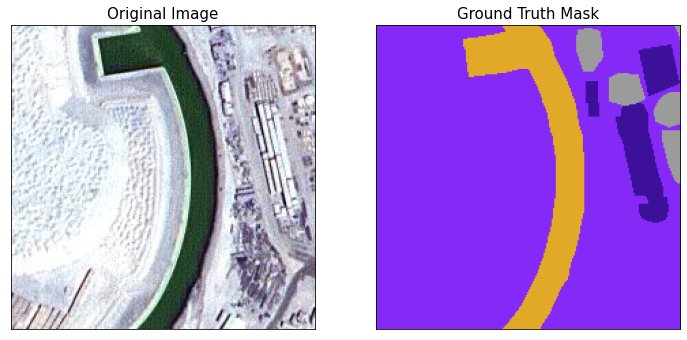

In [ ]:
import cv2
import skimage.io

original_image = skimage.io.imread('/content/Output/imgs/image0000.jpg')
ground_truth_mask = skimage.io.imread('/content/Output/masks/image0000.png')
display(original_image=original_image, ground_truth_mask=ground_truth_mask)

## **One-hot Encode for Masks**

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

data_dir = '/content/Output'
splitfolders.ratio(data_dir, output="train_split", seed=42, ratio=(0.8, 0.1, 0.1))
output_dir = '/content/train_split'

Copying files: 4662 files [00:00, 8389.86 files/s]


| Class Name | Color Hex # | Color RGB |
|--|--|--|
|Water|E2A929|(80, 227, 194)|
|Land (unpaved area)|8429F6|(132, 41, 246)|
|Road|6EC1E4|(110, 193, 228)|
|Building|3C1098|(60, 16, 152)|
|Vegetation|FEDD3A|(254, 221, 58)|
|Unlabeled|9B9B9B|(226, 169, 41)|


In [ ]:
from enum import Enum

# mask color codes
class MaskColorMap(Enum):
    Unlabelled = (155, 155, 155)
    Building = (60, 16, 152)
    Land = (132, 41, 246)
    Road = (110, 193, 228)
    Vegetation = (254, 221, 58)
    Water = (226, 169, 41)

In [ ]:
def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset 
    :param num_classes: number of classes
    :return: 
    """

    img_height, img_width, img_channels = masks.shape

        # create new mask of zeros
    encoded_image = np.zeros((img_height, img_width, 1)).astype(int)

    for j, cls in enumerate(MaskColorMap):
        encoded_image[np.all(masks == cls.value, axis=-1)] = j

    # return one-hot encoded labels
    encoded_image = np.reshape(np.eye(num_classes, dtype=int)[encoded_image],(224,224,6))

    return encoded_image

## **Image Augmentation**

In [ ]:
# Calculate means and stds of the trainset and normalize

train_data = torchvision.datasets.ImageFolder(root = output_dir+'/train', transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5480, 0.4389, 0.6292])
Calculated stds: tensor([0.1554, 0.1918, 0.1756])


In [196]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

data_augmentation = {
    'train': A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=means, std=stds),
    ]),
    'val': A.Compose([
        A.Normalize(mean=means, std=stds),
    ]),
    'test': A.Compose([
        A.Normalize(mean=means, std=stds),
    ]),
}

In [239]:
import torch

from skimage.io import imread

class SemanticSegmentationDataset(torch.utils.data.Dataset):
    """Semantic Segmentation Dataset"""

    def __init__(self, image_dir, mask_dir, image_names, mask_names, transform=None, mask_transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            mask_dir (string): Directory with all the masks.
            image_names (list): List of image names.
            mask_names (list): List of mask names.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.transform = transform
        self.mask_transform = mask_transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])

        image = imread(img_name)
        mask = imread(mask_name)

        # One-hot encoding
        mask = one_hot_encode_masks(mask, 6)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        tenn = transforms.ToTensor()
        image = tenn(image)
        mask = tenn(mask)
        
        return image, mask

In [240]:
import os

Batch_Size = 16
image_datasets = {x: SemanticSegmentationDataset(image_dir=os.path.join(output_dir, x, 'imgs'),
                                                 mask_dir=os.path.join(output_dir, x, 'masks'), 
                                                 image_names=sorted(os.listdir(os.path.join(output_dir, x, 'imgs'))),
                                                 mask_names=sorted(os.listdir(os.path.join(output_dir, x, 'masks'))),
                                                 transform=data_augmentation[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True, 
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

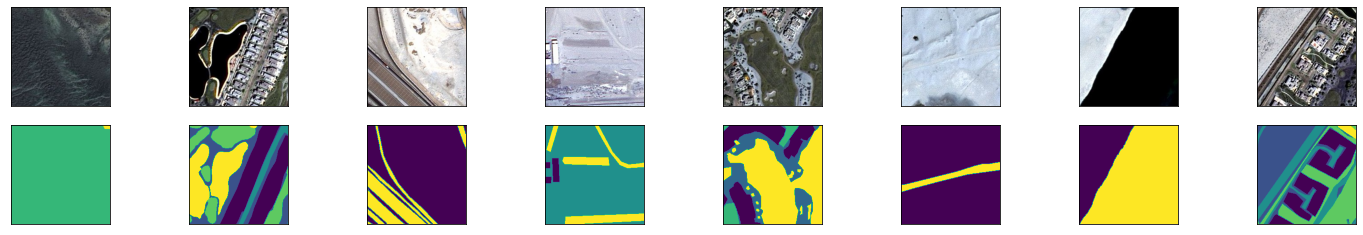

In [242]:
# Visualize some sample data from the original dataset

images, masks = next(iter(dataloaders['test']))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]))
    ax = fig.add_subplot(2, 8, 8+idx+1, xticks=[], yticks=[])
    reverse_encoded = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    plt.imshow(reverse_encoded)

## **Model Loading**

In [ ]:
!pip install segmentation-models-pytorch

In [243]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=6, 
    activation=ACTIVATION,
)

In [ ]:
!pip install torchinfo

In [245]:
from torchinfo import summary

summary(model, 
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                                                       [16, 3, 224, 224]    [16, 6, 224, 224]    --                   True
├─EfficientNetEncoder (encoder)                                   [16, 3, 224, 224]    [16, 3, 224, 224]    806,400              True
│    └─Conv2dStaticSamePadding (_conv_stem)                       [16, 3, 224, 224]    [16, 48, 112, 112]   1,296                True
│    │    └─ZeroPad2d (static_padding)                            [16, 3, 224, 224]    [16, 3, 225, 225]    --                   --
│    └─BatchNorm2d (_bn0)                                         [16, 48, 112, 112]   [16, 48, 112, 112]   96                   True
│    └─MemoryEfficientSwish (_swish)                              [16, 48, 112, 112]   [16, 48, 112, 112]   --                   --
│    └─ModuleList (_blocks)                                  

## **Training Model**

In [ ]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path

# Save the model to the target dir
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    """
    Saves a PyTorch model to a target directory.
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    check_point_name = f"model_epoch_{epoch}"
    model_save_path = target_dir_path / check_point_name

    # Save the model state_dict()
    #print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# Plot the training curve
def plot_curve(results: dict, epochs: int):
    train_ious, val_ious = np.array(results["train_iou"]), np.array(results["val_iou"])
    train_losses, val_losses = np.array(results["train_loss"]), np.array(results["val_loss"])

    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(epochs, step=1), train_ious, label='Train IoU')
    plt.plot(np.arange(epochs, step=1), val_losses, label='Val loss')
    plt.plot(np.arange(epochs, step=1), val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
# Categorical Cross Entropy Loss
class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_hat, y):
        return F.nll_loss(y_hat.log(), y.argmax(dim=1))

# Multiclass Dice Loss
class MultiDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def dice_coef(self, y_pred, y_true, smooth=0.0001):

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f)

        return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

    def dice_coef_multiclass(self, y_pred, y_true, numLabels=6, smooth=0.0001):    
        dice=0

        for index in range(numLabels):
            dice += self.dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 0.0001)

        return 1 - dice/numLabels

    def forward(self, y_pred, y_true):
        #return self.dice_coef_multiclass(torch.softmax(y_pred, dim=1), y_true)
        return self.dice_coef_multiclass(y_pred, y_true)

# Mean IoU Score
class MeanIoU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def IoU_coef(self, y_pred, y_true, smooth=0.0001): 

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f) 
        total = torch.sum(y_true_f + y_pred_f)
        union = total - intersection 
        
        return (intersection + smooth)/(union + smooth)

    def Mean_IoU(self, y_pred, y_true, numLabels=6, smooth=0.0001):
        IoU_Score=0

        for index in range(numLabels):
            IoU_Score += self.IoU_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 1)

        return IoU_Score/numLabels

    def forward(self, y_pred, y_true):
        #return self.Mean_IoU(torch.softmax(y_pred, dim=1), y_true)
        return self.Mean_IoU(y_pred, y_true)

# helper function for image visualization
def display(**images):
    """
    Plot images in one row
    """
    # clear_output(wait=True)
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import time
import numpy as np

from tqdm.auto import tqdm
from tqdm import tqdm, trange

class Trainer:
    def __init__(self, 
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.Dataset,
                 epochs: int, 
                 metric: torch.nn.Module, 
                 criterion: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):
        
        self.model = model
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.epoch = 0
        self.epochs = epochs
        self.metric = metric
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        # Create empty results dictionary
        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }
        
    def train_model(self):
        """
        Train the Model.
        """
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for i in progressbar:
            # Epoch counter
            self.epoch += 1
            #progressbar.set_description(f"Epoch {self.epoch}")

            # Training block
            self.train_epoch()
            #progressbar.set_description(f'\nTrain loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]}')

            # Validation block
            self.val_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]} Val loss: {self.results["val_loss"][-1]} Val iou: {self.results["val_iou"][-1]}')

            # Save checkpoints every epoch
            save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # plot training curve
        plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        """
        Training Mode
        """
        self.model.train() # training mode
        running_ious, running_losses = [], []

        for x, y in self.train_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward - track history if only in train
            outputs = self.model(inputs)
            # Calculate the loss
            loss = self.criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = self.metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)

            # Backward pass
            loss.backward()
            # Update the parameters
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))
        self.results["train_iou"].append(np.mean(running_ious))

    def val_epoch(self):
        """
        Validation Mode
        """
        self.model.eval() # Validation mode
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                # Calculate the loss
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                # Calculate the iou
                iou = self.metric(outputs, targets)
                iou_value = iou.item()
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))

In [ ]:
# Find the test iou of a target model
def evaluate_model(model: torch.nn.Module, 
                   dataloaders: torch.utils.data.DataLoader,
                   metric: torch.nn.Module, 
                   criterion: torch.nn.Module, 
                   device: torch.device):
    """
    Evaluate model performance on testset
    """
    model.eval()
    model.to(device)

    running_ious, running_losses = [], []

    for x, y in dataloaders:
    # Send to device (GPU or CPU)
        inputs = x.to(device)
        targets = y.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)
    
    mean_loss = np.mean(running_losses)
    mean_metric = np.mean(running_ious)
        
    return mean_loss, mean_metric

# Predict the masks
def predict_mask(img: torch.Tensor, 
            model: torch.nn.Module, 
            device: str):

    model.eval()
    model.to(device)

    x = img.to(device)
    with torch.no_grad():
        out = model(x)

    result = torch.softmax(out, dim=1)

    return result

Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Train loss: 0.4933440464323965 Train iou: 0.39294316317757655 Val loss: 0.4816155178206308 Val iou: 0.41299979388713837


Progress:   3%|▎         | 1/30 [01:24<41:03, 84.95s/it]


Epoch 2: Train loss: 0.3829588196400938 Train iou: 0.5049388069531013 Val loss: 0.3726886638573238 Val iou: 0.5143003655331475


Progress:   7%|▋         | 2/30 [02:50<39:40, 85.02s/it]


Epoch 3: Train loss: 0.3564138504965552 Train iou: 0.5337805095417746 Val loss: 0.36941644975117277 Val iou: 0.5162011235952377


Progress:  10%|█         | 3/30 [04:14<38:12, 84.89s/it]


Epoch 4: Train loss: 0.3440228608147851 Train iou: 0.548271728743767 Val loss: 0.36582099965640474 Val iou: 0.5206737284149442


Progress:  13%|█▎        | 4/30 [05:39<36:47, 84.92s/it]


Epoch 5: Train loss: 0.33488767311490814 Train iou: 0.5592315227820955 Val loss: 0.3193128492150988 Val iou: 0.5757335424423218


Progress:  17%|█▋        | 5/30 [07:04<35:17, 84.69s/it]


Epoch 6: Train loss: 0.33804424980591086 Train iou: 0.5548643932260316 Val loss: 0.3049532558236803 Val iou: 0.594295071704047


Progress:  20%|██        | 6/30 [08:28<33:52, 84.67s/it]


Epoch 7: Train loss: 0.3275491759694856 Train iou: 0.5681500362938848 Val loss: 0.3108922711440495 Val iou: 0.5858768267290932


Progress:  23%|██▎       | 7/30 [09:53<32:25, 84.59s/it]


Epoch 8: Train loss: 0.30938568505747566 Train iou: 0.5889438863458305 Val loss: 0.2932471292359488 Val iou: 0.6075085358960288


Progress:  27%|██▋       | 8/30 [11:16<30:55, 84.33s/it]


Epoch 9: Train loss: 0.30435565936154335 Train iou: 0.5938622679176002 Val loss: 0.2933985846383231 Val iou: 0.6058045370238168


Progress:  30%|███       | 9/30 [12:41<29:30, 84.30s/it]


Epoch 10: Train loss: 0.29592281579971313 Train iou: 0.603937294719548 Val loss: 0.27729556815964834 Val iou: 0.625308769089835


Progress:  33%|███▎      | 10/30 [14:06<28:15, 84.76s/it]


Epoch 11: Train loss: 0.2918323627833662 Train iou: 0.6090443478576069 Val loss: 0.2817245806966509 Val iou: 0.6170468585831779


Progress:  37%|███▋      | 11/30 [15:31<26:49, 84.72s/it]


Epoch 12: Train loss: 0.29046760139794187 Train iou: 0.6096933273405865 Val loss: 0.28524693846702576 Val iou: 0.6114771962165833


Progress:  40%|████      | 12/30 [16:55<25:19, 84.44s/it]


Epoch 13: Train loss: 0.2853912670036842 Train iou: 0.6150313944652163 Val loss: 0.2843910540853228 Val iou: 0.6180883518287114


Progress:  47%|████▋     | 14/30 [19:43<22:27, 84.25s/it]


Epoch 14: Train loss: 0.2852010202818903 Train iou: 0.6130472370262804 Val loss: 0.27596633774893625 Val iou: 0.6215635452951703

Epoch 15: Train loss: 0.27807387966534186 Train iou: 0.6215817211516972 Val loss: 0.27948873383658274 Val iou: 0.6196592918464116


Progress:  53%|█████▎    | 16/30 [22:31<19:35, 83.95s/it]


Epoch 16: Train loss: 0.2762058988727372 Train iou: 0.6235422954477113 Val loss: 0.27997574635914396 Val iou: 0.620618964944567


Progress:  57%|█████▋    | 17/30 [23:56<18:16, 84.31s/it]


Epoch 17: Train loss: 0.27370029739264784 Train iou: 0.6264024351177544 Val loss: 0.27922058531216215 Val iou: 0.6200826593807766

Epoch 18: Train loss: 0.27427971363067627 Train iou: 0.6254920969749319 Val loss: 0.268807121685573 Val iou: 0.6273193572248731


Progress:  63%|██████▎   | 19/30 [26:45<15:29, 84.52s/it]


Epoch 19: Train loss: 0.2729588366788009 Train iou: 0.6256961000376734 Val loss: 0.28172753538404194 Val iou: 0.6170671326773507

Epoch 20: Train loss: 0.27436213349473887 Train iou: 0.6270111642521004 Val loss: 0.2879928009850638 Val iou: 0.6103906972067696


Progress:  67%|██████▋   | 20/30 [28:10<14:07, 84.73s/it]


Epoch 21: Train loss: 0.2749298256019066 Train iou: 0.6237312280412378 Val loss: 0.28640419244766235 Val iou: 0.612587456192289


Progress:  73%|███████▎  | 22/30 [31:00<11:17, 84.69s/it]


Epoch 22: Train loss: 0.27182619838879024 Train iou: 0.6259243123490235 Val loss: 0.27532890013286043 Val iou: 0.6210888070719582


Progress:  77%|███████▋  | 23/30 [32:24<09:52, 84.59s/it]


Epoch 23: Train loss: 0.27449624445931664 Train iou: 0.6257293229473049 Val loss: 0.27660770075661795 Val iou: 0.6212489051478249

Epoch 24: Train loss: 0.2763173688074638 Train iou: 0.6234697550535202 Val loss: 0.27469320382390705 Val iou: 0.6282095738819667


Progress:  80%|████████  | 24/30 [33:49<08:27, 84.64s/it]


Epoch 25: Train loss: 0.27447493117431115 Train iou: 0.623898162410177 Val loss: 0.2678865449769156 Val iou: 0.6303477755614689


Progress:  83%|████████▎ | 25/30 [35:14<07:03, 84.74s/it]


Epoch 26: Train loss: 0.26812570310872175 Train iou: 0.6294915917618521 Val loss: 0.2642864201750074 Val iou: 0.6324083294187274


Progress:  87%|████████▋ | 26/30 [36:38<05:38, 84.68s/it]


Epoch 27: Train loss: 0.2722740414841422 Train iou: 0.6268730677407364 Val loss: 0.27132529871804373 Val iou: 0.6267116665840149


Progress:  90%|█████████ | 27/30 [38:03<04:14, 84.73s/it]


Epoch 28: Train loss: 0.2738317467015365 Train iou: 0.6251165866851807 Val loss: 0.2803259321621486 Val iou: 0.617981846843447


Progress:  93%|█████████▎| 28/30 [39:28<02:49, 84.66s/it]


Epoch 29: Train loss: 0.2714609621927656 Train iou: 0.6285173132501799 Val loss: 0.2747892269066402 Val iou: 0.6243407300540379


Progress: 100%|██████████| 30/30 [42:17<00:00, 84.59s/it]


Epoch 30: Train loss: 0.2730246751472868 Train iou: 0.6264292073660883 Val loss: 0.27802011370658875 Val iou: 0.6192160163606916
--------------------
Training complete in 42m 18s


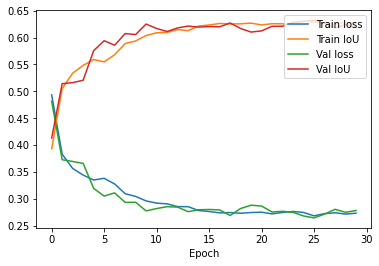

In [203]:
## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
model = model.to(device)
metric_UNet = MeanIoU()
criterion_UNet = MultiDiceLoss()
optimizer_UNet = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

# Trainer
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=30,
                  metric=metric_UNet,
                  criterion=criterion_UNet, 
                  optimizer=optimizer_UNet,
                  scheduler=exp_lr_scheduler_UNet,
                  save_dir="UNet_Model_Output",
                  device=device)

## Training process
model_results = trainer.train_model()

## **Evaluation on Testset**

In [247]:
model_state = torch.load('/content/UNet_Model_Output/model_epoch_30')
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
## Model inItialization
# model = model.to(device)
metric_DeepLab_V3 = MeanIoU()
criterion_DeepLab_V3 = MultiDiceLoss()
optimizer_DeepLab_V3 = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_DeepLab_V3 = lr_scheduler.StepLR(optimizer_DeepLab_V3, step_size=7, gamma=0.1)

In [ ]:
outputs = evaluate_model(model=model, dataloaders=dataloaders['val'], 
                           metric=metric_DeepLab_V3, criterion=criterion_DeepLab_V3,
                           device=device)

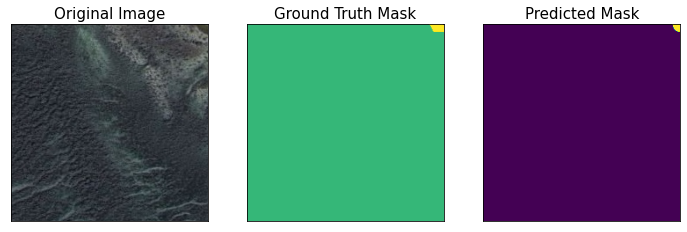

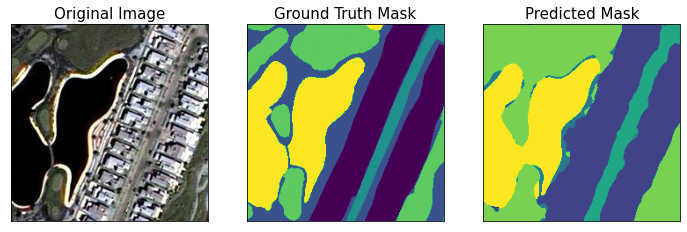

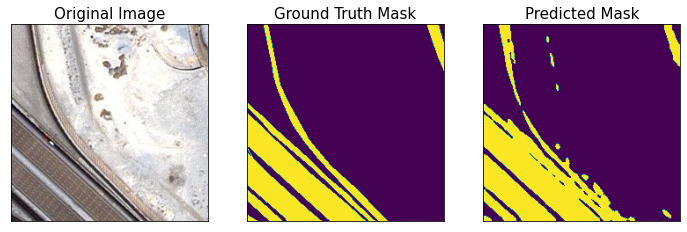

In [248]:
for idx in range(3):
    original_image = np.transpose(images[idx])
    ground_truth_mask = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    res = predict_mask(img=images, model=model, device=device)
    predicted_mask = np.transpose(np.argmax(res[idx].to('cpu'), axis=0, keepdims=True))
    display(original_image=original_image, ground_truth_mask=ground_truth_mask, predicted_mask=predicted_mask)

In [1]:
%%shell
jupyter nbconvert --to html /content/Semantic_Segmentation_of_Aerial_Imagery.ipynb

[NbConvertApp] Converting notebook /content/Semantic_Segmentation_of_Aerial_Imagery.ipynb to html
[NbConvertApp] Writing 1745529 bytes to /content/Semantic_Segmentation_of_Aerial_Imagery.html
